#heading

In [8]:
!git clone https://github.com/duomei98/chemical-hazards.git

fatal: could not create work tree dir 'chemical-hazards': Permission denied


In [11]:
#why doesn't the sdsc have tensorflow/keras/
%pip install keras_tuner

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 15.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
!pwd

/home/yxie10


In [2]:
#import tensorflow as tf
import pandas as pd
import numpy as np
import keras
import re
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import *
from sklearn.metrics import accuracy_score
import keras_tuner

def precision(y, yhat):
    if len([x for x in yhat if x == 1]) == 0:
        return 0
    ytot = np.column_stack((y, yhat))
    return len([x for x in ytot if x[0] == 1 and x[0] == x[1]])/len([x for x in yhat if x == 1])

def recall(y, yhat):
    ytot = np.column_stack((y, yhat))
    return len([x for x in ytot if x[0] == 1 and x[0] == x[1]])/len([x for x in y if x == 1])

def f1(y, yhat):
    return 2*precision(y,yhat)*recall(y,yhat)/(precision(y,yhat)+recall(y,yhat))

In [2]:
!pip install deepchem
from deepchem.feat.smiles_tokenizer import BasicSmilesTokenizer
tokenizer = BasicSmilesTokenizer()

Defaulting to user installation because normal site-packages is not writeable


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
There was a problem when trying to write in your cache folder (/home/jovyan/.cache/huggingface/hub). You should set the environment variable TRANSFORMERS_CACHE to a writable directory.


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/yxie10/.local/lib/python3.11/site-packages/deepchem/models/torch_models/__init__.py)
Matplotlib created a temporary cache directory at /scratch/yxie10/job_32605241/matplotlib-rtj3drat because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [21]:
overalldf = pd.read_csv('final-data-csv.csv')
#overalldf

In [22]:
overalldf['len'] = overalldf['SMILES'].apply(lambda x: len(tokenizer.tokenize(x)))

We're going to be training on molecules with SMILES string length of 100 tokens or less, which roughly corresponds to the ~1 kilodalton size of a "small molecule" and should cover most commonly used reagents.

In [23]:
shortdf = overalldf[overalldf['len'] <= 100]
del overalldf

generating a mapping to reduce the tokens later:

In [39]:
!git clone https://github.com/EBjerrum/SMILES-enumeration.git

Cloning into 'SMILES-enumeration'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 80 (delta 9), reused 24 (delta 7), pack-reused 49
Receiving objects: 100% (80/80), 356.97 KiB | 3.08 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [14]:
%cd SMILES-enumeration

/home/yxie10/SMILES-enumeration


In [24]:
from SmilesEnumerator import SmilesEnumerator
sme = SmilesEnumerator()
shortdf = shortdf.drop(columns=['len','CID'])


In [16]:
np.sum(shortdf.drop(columns=['SMILES']))

explosive                  207
flammable                13258
oxidizer                   434
pressurized                297
corrosive                34656
toxic                    15080
irritant                185519
health hazard            14979
environmental hazard     17703
dtype: int64

We're going to add alternate smiles for the explosive, oxidizer, and pressurized hazard classes.

In [ ]:
#repeats is the number of times we attempt to add another smile
def addSmiles(hazards, repeats, shortdf):
    smiles = set()
    newdf = [shortdf]
    for hazard in hazards:
        print(hazard.upper(), ':\n')
        comps = shortdf[shortdf[hazard] == 1]
        smiles.update(comps['SMILES'])
        for comp in comps.iterrows():
            #print(comp[1][0])     #uncomment to see which smiles is ducking up the code
            try: #some SMILES are not compatible with the smiles randomizer, we'll ignore those
                alt = sme.randomize_smiles(comp[1][0])
            except:
                print(comp[1][0], "isn't quite valid")
                continue;
            for i in range(repeats):
                #print(np.transpose(np.array(comp[1].to_numpy())))
                row = pd.DataFrame(np.transpose(comp[1].to_numpy()[:,np.newaxis]), columns=comp[1].index)
                #return row
                #print(comp[1][0])
                alt = sme.randomize_smiles(comp[1][0])
                if alt not in smiles:
                    smiles.add(alt)
                    #print(alt)
                    row['SMILES']=alt
                    newdf.append(row)
    return pd.concat(newdf, axis=0)

shortdf = addSmiles(['explosive', 'oxidizer', 'pressurized'], 100, shortdf)
shortdf

In [27]:
shortdf.to_csv(path_or_buf='../augmented-final-data.csv')

converting the SMILES into a one-hot matrix

In [28]:
np.sum(shortdf.drop(columns=['SMILES']))

explosive                10554
flammable                18120
oxidizer                 19162
pressurized               2126
corrosive                42727
toxic                    19888
irritant                208832
health hazard            23378
environmental hazard     25957
dtype: object

In [29]:
shortdf['len'] = shortdf['SMILES'].apply(lambda x: len(tokenizer.tokenize(x)))

In [30]:
shortdf.describe()

,len
count,248584.000000
mean,31.790023
std,16.325799
min,1.000000
25%,21.000000
50%,27.000000
75%,39.000000
max,100.000000


In [37]:
tokens = set()
for smile in shortdf['SMILES']:
  tokens.update(tokenizer.tokenize(smile))

In [ ]:
#dictionary of ions: raw tokens corresponding to final ion/ligand/whatever i'm not a chem person category
# ion: charge (n/+/-) + type (metal/organic)
iondict={}
organics = ['B', 'Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'O','P','S']
for token in tokens:
  if token[0] == '[' and token[-1] == ']':
    if token[1:-1] in organics or token[1:-1].upper() in organics:
      continue
    mo = 'o' if re.search('[a-zA-Z][a-z]?', token)[0] in organics or re.search('[a-zA-Z][a-z]?', token)[0].upper() in organics else 'm';
    charge = '-' if token.find('-') >= 0 else '+' if token.find('+') >= 0 else 'n'
    iondict[token] = charge+mo
iondict

In [46]:
#obtaining the data we'll be directly using for our model
# input: smiles converted into a vector of one-hot encoded (ish) vector
type2idx = {  # key:
    'nm': 0,  # neutral metal
    '+m': 1,  # positively charged metal
    '-m': 2,  # negatively charged metal
    'no': 3,  # neutral organic
    '+o': 4,  # positively charged organic
    '-o': 5   # negatively charged organic
}
def untoken(token):
  tok = np.zeros(22);
  #if ion:
  if token[0] == '[':
    if token[1:-1] in organics:
      tok[organics.index(token[1:-1])+11] = 1
      return tok
    iontype = iondict[token]
    tok[type2idx[iontype]] = 1;
  elif token == ')':
    tok[6] = -1
  elif token == '(':
    tok[6] = 1
  elif token.isdigit():
    tok[7] = float(token)/10
  elif token == '#':
    tok[8] = 1
  elif token == '=':
    tok[9] = 1
  elif token == '.' or token == '-':
    tok[10] = 1
  else:
    if token in organics:
        tok[organics.index(token)+11] = 1
    else:
        tok[organics.index(token.upper())+11] = 1
  return tok

def unsmile(smile):
  vec = np.zeros(shape=(100,22))
  tokens = tokenizer.tokenize(smile)
  for i in range(len(tokens)):
    vec[i] = untoken(tokens[i])
  return vec

smilesnp = np.zeros(shape=(len(shortdf['SMILES']), 100, 22))
i=0
for smile in shortdf['SMILES']:
  smilesnp[i] = unsmile(smile)
  i +=1

In [4]:
y = shortdf.drop(columns=['SMILES','Unnamed: 0'])
np.sum(y)

explosive                10554
flammable                18120
oxidizer                 19162
pressurized               2126
corrosive                42727
toxic                    19888
irritant                208832
health hazard            23378
environmental hazard     25957
dtype: int64

In [47]:
smilesnp.shape

(248584, 100, 22)

In [49]:
np.save('../aug-smilesnp.npy', smilesnp)

In [50]:
del tokens
del shortdf

In [3]:
#loading from before...
shortdf = pd.read_csv('augmented-final-data.csv')
smilesnp = np.load('aug-smilesnp.npy')


In [5]:
X_train, X_test, y_train, y_test = train_test_split(smilesnp, y, test_size=0.2, random_state=21)

Model building and training time:
(and deleting extra variables to save ram because colab hates me :( )

In [7]:
X_train.shape

(198867, 100, 22)

In [6]:
#building vnn (vanilla neural net) model
#VNNACTIVATIONFXN = 'tanh'
#vnn = Sequential()
#vnn.add(Input(shape=(2200,)))
#vnn.add(Dense(units = 10, activation = VNNACTIVATIONFXN))
#vnn.add(Dense(units = 9, activation = VNNACTIVATIONFXN))
#vnn.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')

#building cnn model
CNNACTIVATIONFXN = 'sigmoid'
cnn = Sequential();
cnn.add(Conv1D(32, kernel_size=5, activation='relu', input_shape=(100,22)))
cnn.add(MaxPooling1D())
#cnn.add(Conv1D(32, kernel_size=5, activation='relu'))
#cnn.add(MaxPooling1D())
cnn.add(Flatten())
cnn.add(Dense(units = 64, activation = CNNACTIVATIONFXN))
cnn.add(Dense(units = 32, activation = CNNACTIVATIONFXN))
cnn.add(Dense(units = 32, activation = CNNACTIVATIONFXN))
cnn.add(Dense(units = 9, activation = 'tanh'))
cnn.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', metrics=['accuracy'])

#fitting model
early_stopping = keras.callbacks.EarlyStopping(
    #Enter your parameters
    monitor='loss',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

#vnn_history = vnn.fit(X_train.reshape((len(X_train), 2200)), y_train, batch_size = 128, epochs = 10, callbacks = [], verbose = 1)
cnn_history = cnn.fit(X_train, y_train, batch_size = 128, epochs = 10, callbacks = [early_stopping], verbose = 1)

/home/yxie10/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5844 - loss: 0.0773
Epoch 2/10
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6606 - loss: 0.0612
Epoch 3/10
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6792 - loss: 0.0561
Epoch 4/10
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6937 - loss: 0.0526
Epoch 5/10
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.7025 - loss: 0.0504
Epoch 6/10
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7086 - loss: 0.0486
Epoch 7/10
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.7126 - loss: 0.0471
Epoch 8/10
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7131 - loss: 0.0462
Epoch 9/10
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7169 - loss: 0.0448
Epoch 10/10
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7180 - loss: 0.0438


In [13]:
#model evaluation
'''
vnn_yhat_test = vnn.predict(X_test.reshape(len(X_test), 2200))
vnn_yhat_test = np.where(vnn_yhat_test > 0.5, 1, 0)
print("VNN accuracy:", accuracy_score(y_test, vnn_yhat_test))

i=0
vnn_yhat_test_classes = np.transpose(vnn_yhat_test)
for hazard in y_test:
    print(hazard, "precision:", precision(y_test[hazard], vnn_yhat_test_classes[i]))
    print(hazard, "recall:", recall(y_test[hazard], vnn_yhat_test_classes[i]))
    print()
    i += 1
''' #in general the vnn performs worse than the cnn

cnn_yhat_test = cnn.predict(X_test)
cnn_yhat_test = np.where(cnn_yhat_test > 0.5, 1, 0)
print("\nCNN accuracy:", accuracy_score(y_test, cnn_yhat_test))
i=0
cnn_yhat_test_classes = np.transpose(cnn_yhat_test)
for hazard in y_test:
    print(hazard, "precision:", precision(y_test[hazard], cnn_yhat_test_classes[i]))
    print(hazard, "recall:", recall(y_test[hazard], cnn_yhat_test_classes[i]))
    print()
    i += 1

NameError: name 'cnn' is not defined

In [9]:
# tuning

def buildHPmodel(hp):
    activation= hp.Choice("activation", ["sigmoid", "tanh",'relu'])
    finalactivation= hp.Choice("output activation", ["sigmoid", "tanh"])
    units =  int(hp.Int("units", min_value=16, max_value=64, step=2, sampling='log'))
    
    cnn = Sequential();
    cnn.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(100,22)))
    cnn.add(MaxPooling1D())
    cnn.add(Flatten())

    for i in range(hp.Int("num_layers", 2, 4)):
        cnn.add(Dense(units=units, activation=activation))

    cnn.add(Dense(units = 9, activation = finalactivation))
    opt = keras.optimizers.RMSprop(learning_rate = 0.05)
    cnn.compile(optimizer = opt, loss = 'mean_squared_error', metrics=['accuracy'])
    return cnn

hp = keras_tuner.HyperParameters()

tuner = keras_tuner.GridSearch(
    hypermodel=buildHPmodel,
    objective="val_accuracy",
    max_trials=55,
    seed=15,
    executions_per_trial=5,
    #hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    #max_retries_per_trial=0,
    max_consecutive_failed_trials=3,
    overwrite=False,
    project_name="final_tuning"
)

tuner.search_space_summary()

Reloading Tuner from ./final_tuning/tuner0.json
Search space summary
Default search space size: 4
activation (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid', 'tanh', 'relu'], 'ordered': False}
output activation (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid', 'tanh'], 'ordered': False}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 2, 'sampling': 'log'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}


In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 0)

In [10]:
tuner.search(X_train, y_train, epochs=5, batch_size = 512, validation_data=(X_val, y_val))
tuner.results_summary(num_trials=5)
hps = tuner.get_best_hyperparameters(num_trials=5)

Results summary
Results in ./final_tuning
Showing 5 best trials
Objective(name="val_accuracy", direction="max")

Trial 09 summary
Hyperparameters:
activation: sigmoid
output activation: tanh
units: 16
num_layers: 2
Score: 0.7000060319900513

Trial 03 summary
Hyperparameters:
activation: sigmoid
output activation: sigmoid
units: 32.0
num_layers: 2
Score: 0.6946195363998413

Trial 06 summary
Hyperparameters:
activation: sigmoid
output activation: sigmoid
units: 64.0
num_layers: 2
Score: 0.6930386066436768

Trial 01 summary
Hyperparameters:
activation: sigmoid
output activation: sigmoid
units: 16
num_layers: 3
Score: 0.6900858879089355

Trial 04 summary
Hyperparameters:
activation: sigmoid
output activation: sigmoid
units: 32.0
num_layers: 3
Score: 0.6893859148025513


In [ ]:

num=0
X_train, X_test, y_train, y_test = train_test_split(smilesnp, y, test_size=0.2, random_state=21)

early_stopping = keras.callbacks.EarlyStopping(
    #Enter your parameters
    monitor='loss',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

for hp in hps:
    print('Model', num, ":\n")
    model = tuner.hypermodel.build(hp)
    model.fit(X_train, y_train, batch_size = 1024, epochs = 30, verbose = 0)
    yhat_test = model.predict(X_test)
    yhat_test = np.where(yhat_test > 0.5, 1, 0)
    print("\nAccuracy:", accuracy_score(y_test, yhat_test))
    i=0
    yhat_test_classes = np.transpose(yhat_test)
    for hazard in y_test:
        print(hazard, "precision:", precision(y_test[hazard], yhat_test_classes[i]))
        print(hazard, "recall:", recall(y_test[hazard], yhat_test_classes[i]))
        print()
        i += 1
    num += 1

In [27]:
print(hps[3].values)

{'activation': 'sigmoid', 'output activation': 'sigmoid', 'units': 16, 'num_layers': 3}


In [5]:
# looks like more layer + more units per layer ends up yielding better results on both test and train data, so we'll try that ?
# still not really sure how to improve recall over precision though...

CNNACTIVATIONFXN = 'sigmoid'
final_cnn = Sequential();
final_cnn.add(Conv1D(32, kernel_size=5, activation='relu', input_shape=(100,22)))
final_cnn.add(MaxPooling1D())
#final_cnn.add(Conv1D(32, kernel_size=5, activation='relu'))
#final_cnn.add(MaxPooling1D())
final_cnn.add(Flatten())
final_cnn.add(Dense(units = 64, activation = CNNACTIVATIONFXN))
final_cnn.add(Dense(units = 64, activation = CNNACTIVATIONFXN))
final_cnn.add(Dense(units = 64, activation = CNNACTIVATIONFXN))
final_cnn.add(Dense(units = 9, activation = 'sigmoid'))
final_cnn.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', metrics=['accuracy'])

model_history = final_cnn.fit(X_train, y_train, batch_size = 128, epochs = 50, verbose = 1)
yhat_test = final_cnn.predict(X_test)
yhat_test = np.where(yhat_test > 0.5, 1, 0)

/home/yxie10/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.5717 - loss: 0.0861
Epoch 2/50
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.5787 - loss: 0.0799
Epoch 3/50
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.5799 - loss: 0.0785
Epoch 4/50
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.5923 - loss: 0.0731
Epoch 5/50
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.6170 - loss: 0.0715
Epoch 6/50
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.6203 - loss: 0.0705
Epoch 7/50
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.6206 - loss: 0.0695
Epoch 8/50
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.6249 - loss: 0.0676
Epoch 9/50
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.6287 - loss: 0.0655
Epoch 10/50
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.6484 - loss: 0.0634
Epoch 11/50
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.6568 - loss: 0.0621
Epoch 12/50
1554/

In [6]:
print("\nOverall Accuracy:", accuracy_score(y_test, yhat_test))
i=0
yhat_test_classes = np.transpose(yhat_test)
acc = []
prec = []
rec = []
for hazard in y_test:
    print(hazard, "accuracy:", accuracy_score(y_test[hazard], yhat_test_classes[i]))
    acc.append(accuracy_score(y_test[hazard], yhat_test_classes[i]))
    print(hazard, "precision:", precision(y_test[hazard], yhat_test_classes[i]))
    prec.append(precision(y_test[hazard], yhat_test_classes[i]))
    print(hazard, "recall:", recall(y_test[hazard], yhat_test_classes[i]))
    rec.append(recall(y_test[hazard], yhat_test_classes[i]))
    print()
    i += 1


Overall Accuracy: 0.6520304925880483
explosive accuracy: 0.9935032282720196
explosive precision: 0.9039341262580055
explosive recall: 0.9459071325993298

flammable accuracy: 0.9586660498421063
flammable precision: 0.7145697245100824
flammable recall: 0.7055524397083567

oxidizer accuracy: 0.9935836836494559
oxidizer precision: 0.982281284606866
oxidizer recall: 0.9329476728898238

pressurized accuracy: 0.9973047448558843
pressurized precision: 0.8871391076115486
pressurized recall: 0.7878787878787878

corrosive accuracy: 0.8892531729589477
corrosive precision: 0.7809486321590238
corrosive recall: 0.47458437985886853

toxic accuracy: 0.9323772552647988
toxic precision: 0.7481234361968306
toxic recall: 0.2266868840030326

irritant accuracy: 0.8664239596114005
irritant precision: 0.8943674644592406
irritant recall: 0.9533629061263638

health hazard accuracy: 0.9324778244865941
health hazard precision: 0.7692307692307693
health hazard recall: 0.38511749347258484

environmental hazard accu

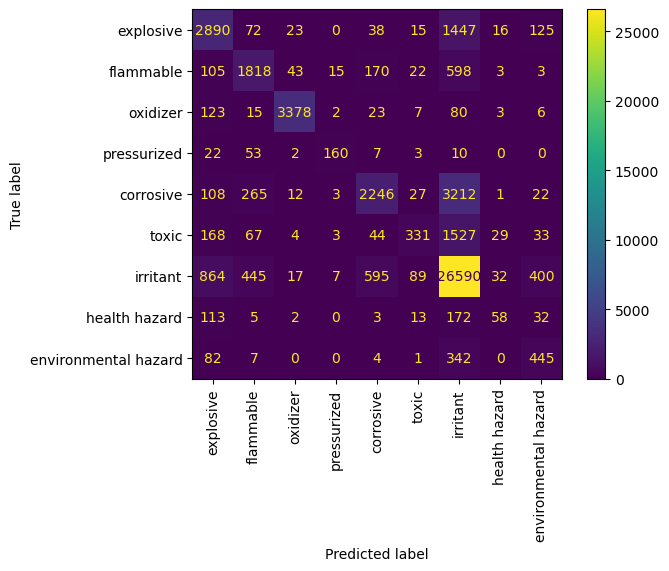

In [26]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

#cmatrix_test = multilabel_confusion_matrix(y_test, yhat_test)#, labels=y_test.columns)
#for plot, haz in zip(cmatrix_test, y_test.columns):
#    cmdisptest = ConfusionMatrixDisplay(confusion_matrix=plot)#, display_labels=y_test.columns)
#    cmdisptest.plot()

cm = confusion_matrix(y_test.to_numpy().argmax(axis=1), yhat_test.argmax(axis=1))

classes = y_test.columns
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_test.columns)
cm_disp.plot(values_format='d', xticks_rotation='vertical')


Text(0.5, 1.0, 'Accuracy')

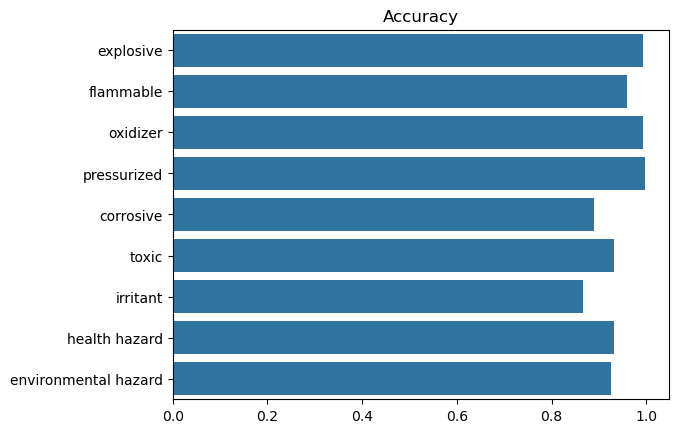

In [32]:
import seaborn as sb
accd = {y_test.columns[i] : acc[i] for i in range(len(acc))}
precd = {y_test.columns[i] : prec[i] for i in range(len(acc))}
recd = {y_test.columns[i] : rec[i] for i in range(len(acc))}
sb.barplot(data=accd, orient='h').set_title('Accuracy')


Text(0.5, 1.0, 'Precision')

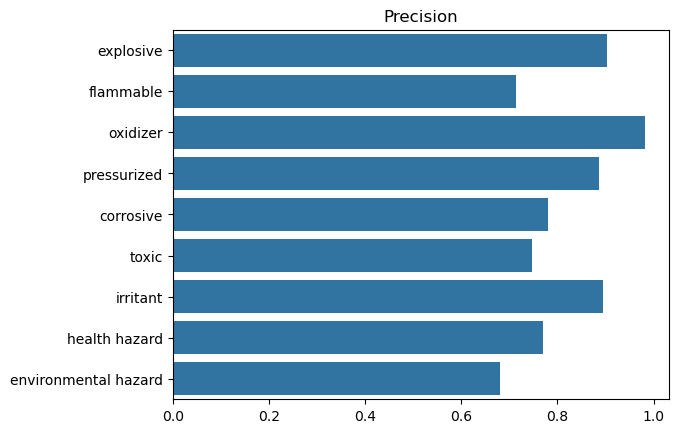

In [33]:
sb.barplot(data=precd, orient='h').set_title('Precision')

Text(0.5, 1.0, 'Recall')

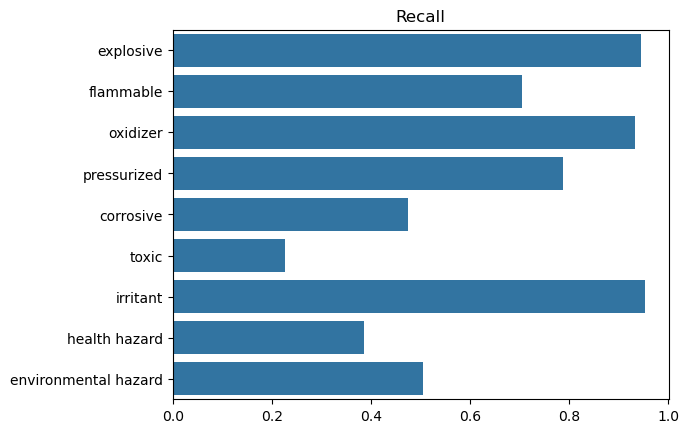

In [34]:
sb.barplot(data=recd, orient='h').set_title('Recall')